In [1]:
import glob
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

maxDischargeTemperatures = [-5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
maxDischargeRates = [0, 0, 0, 10.73759, 22.42149, 36.0174, 56.8107, 54.50289,
                     62.88506, 70.23952]
maxDischargePower = interp1d(maxDischargeTemperatures, maxDischargeRates,
                             kind="linear")

In [2]:
files = glob.glob('./output/mult/*')

print(files)

[]


In [100]:
base = pd.read_pickle('./output/heh/0003_Base_Load_300_const.pkl')
load1 = pd.read_pickle('./output/heh/0003_Load_1_300_const.pkl')
load5 = pd.read_pickle('./output/heh/0003_Load_5_300_const.pkl')
load5h = pd.read_pickle('./output/heh/0003_Load_5H_300_const.pkl')
loadma = pd.read_pickle('./output/heh/0003_Load_MA_300_const.pkl')
pred = pd.read_pickle('./output/heh/0003_Pred_300_const.pkl')
price1 = pd.read_pickle('./output/heh/0003_Price_1_300_const.pkl')
priced = pd.read_pickle('./output/heh/0003_Price_DUoS_300_const.pkl')

In [102]:
base = pd.read_pickle('./output/heh/0003_Base_Load_300_dyn.pkl')
load1 = pd.read_pickle('./output/heh/0003_Load_1_300_dyn.pkl')
load5 = pd.read_pickle('./output/heh/0003_Load_5_300_dyn.pkl')
load5h = pd.read_pickle('./output/heh/0003_Load_5H_300_dyn.pkl')
loadma = pd.read_pickle('./output/heh/0003_Load_MA_300_dyn.pkl')
pred = pd.read_pickle('./output/heh/0003_Pred_300_dyn.pkl')
price1 = pd.read_pickle('./output/heh/0003_Price_1_300_dyn.pkl')
priced = pd.read_pickle('./output/heh/0003_Price_DUoS_300_dyn.pkl')

In [239]:
out = []

In [240]:


dats = []
dats.append(base)
dats.append(load1)
dats.append(load5)
dats.append(load5h)
dats.append(loadma)
dats.append(pred)
dats.append(price1)
dats.append(priced)
#print(base)



const = "_const"
dyn = "_dyn"
names = ['20-11-SA-Base', '20-11-SA-load1', '20-11-SA-load5', '20-11-SA-load5h', '20-11-SA-laodma', '20-11-SA-pred',                          '20-11-SA-price1', '20-11-SA-duos']

# print(base[base['Temp'] > 20])

for (d, n)in zip(dats, names):
    outb = pd.DataFrame()
    outb['date'] = d['Date']
    outb['HH'] = d['HH']
    outb['COE'] = d['BAU COE']
    outb['T'] = d['Temp']
    outb['BAU El'] = base['Loads(kWh)']
    outb['COP'] = d['COP']
    outb['BAU The'] = d['Loads(kWh)'] * d['COP'] / 0.5 
    outb['PCM Mode'] = d['Mode']
    outb['Q'] = d['Q_dot']
    outb['SOC'] = d['SOC']
    #outb['Q'] = outb.apply(lambda row: max(row['Q'], -2 * maxDischargePower(row['T'])*row['BAU El']*row['COP']/100) if row['Q'] < 0 else row['Q'], axis=1)
    outb['SoCdelta'] = d['sDelta']
    outb['MaxDis'] = base.apply(lambda row: max(-80, round(-2 * maxDischargePower(row['Temp'])*row['Loads(kWh)']*row['COP']/100, 1)), axis=1)
    outb['BAU Cost (GBP)'] = (d['Loads(kWh)'] * d['BAU COE'] ) / 100
    #outb['Real Cost'] = d['Loads'] d['Q_dot'] / d['COP'] * d['dt * CoE'] / 100
    out.append((n+dyn, outb))
    #outb.to_csv("./post/" + n + dyn +".csv", index=False)

#print(outb)





In [241]:
def applyConst(out, base):
    newQ = []
    for index, row in out.iterrows():
        if (row['PCM Mode'] == 'discharging'):
            if (row['MaxDis'] > row['Q']):
                newQ.append(row['MaxDis'])
            else:
                
                #print("index:",index)
                if (row['Q'] > base.at[base.index[index], 'Q']):
                    newQ.append(base.at[base.index[index], 'Q'])
                else:
                    newQ.append(row['Q'])
        else:
            newQ.append(row['Q'])
    return newQ

# out[1][1]['NQ'] = applyConst(out[1][1], out[0][1]) 
# out[1][1]['Q'] = out[1][1]['NQ']

# print(out[1][1].loc[out[1][1]['NQ'] > out[0][1]['Q']])

In [242]:
def calcSOC(out):
    soc = 0
    sc = []
    qup = []
    for index, row in out.iterrows():
        if (row['date'].day == 1 and row['HH'] == 1):
            soc = row['NQ'] / 2.
            #print(soc)
        else:
            soc += row['NQ'] / 2.
        if soc > 300:
            qup.append((row['NQ']/2 - (soc - 300))*2)
            soc = 300
        elif soc < 0:
            qup.append((row['NQ']/2 - soc)*2)
            soc = 0
        else:
            qup.append(row['NQ'])
        # if (row['date'].day == 1 and row['HH'] == 2):
        #     print(soc)
        # if (soc > 1000):
        #     print("What!!!??!?!")
        soc = round(soc, 1)
        sc.append(soc)
    return(sc, qup)
            

2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01
2019-12-01


In [243]:
print(out[4][0])

out[0][1][['Q', 'MaxDis', "BAU El"]]


20-11-SA-laodma_dyn


,Q,MaxDis,BAU El
0,0.0,-0.0,21
1,0.0,-0.0,23
2,0.0,-0.0,23
3,0.0,-0.0,22
4,0.0,-0.0,20
...,...,...,...
16075,0.0,-0.0,37
16076,0.0,-0.0,36
16077,0.0,-0.0,36
16078,0.0,-0.0,33


In [257]:
out[3][1]['NQ'] = applyConst(out[3][1], out[0][1]) 
#out[3][1]['Q'] = out[3][1]['NQ']

out[3][1]['NSOC'], out[3][1]['NQ'] = calcSOC(out[3][1])

out[0][1]['NQ'] = out[0][1]['Q'] 
out[0][1]['NSOC'], _ = calcSOC(out[0][1])
out[4][1]['NQ'] = applyConst(out[3][1], out[0][1]) 
out[4][1]['NSOC'], out[4][1]['NQ'] = calcSOC(out[4][1])
#out[4][1]['Q'] = out[4][1]['NQ']

In [258]:
print(out[0][1].loc[out[0][1]['SOC'] != out[0][1]['NSOC']])

Empty DataFrame
Columns: [date, HH, COE, T, BAU El, COP, BAU The, PCM Mode, Q, SOC, SoCdelta, MaxDis, BAU Cost (GBP), NSOC, NQ]
Index: []


In [265]:

print(out[4][1].loc[out[4][1]['NSOC'] < -5])

            date  HH    COE     T  BAU El    COP  BAU The     PCM Mode  \
3878  2019-04-21  39  12.98  18.0      36  2.662  191.664  discharging   
3879  2019-04-21  40  11.33  17.0      38  2.798  201.456      standby   
3880  2019-04-21  41   8.93  17.0      33  2.798  201.456      standby   
3883  2019-04-21  44   9.66  14.0      33  3.214  231.408  discharging   
3884  2019-04-21  45   8.14  14.0      31  3.214  231.408      standby   
3925  2019-04-22  38  12.47  18.0      53  2.662  191.664  discharging   
3926  2019-04-22  39  12.10  18.0      49  2.662  191.664      standby   
3927  2019-04-22  40  10.45  17.0      46  2.798  201.456      standby   
3928  2019-04-22  41   8.69  17.0      41  2.798  201.456      standby   
3929  2019-04-22  42   7.92  17.0      42  2.798  201.456      standby   
3930  2019-04-22  43   7.85  17.0      42  2.798  201.456      standby   
3932  2019-04-22  45   7.70  16.0      45  2.934  211.248  discharging   
3974  2019-04-23  39  11.35  15.0     

In [250]:
dates = out[0][1]['date'].unique()

print(out[3][1][['HH', 'Q', 'NQ', 'MaxDis', 'NSOC', 'SOC']].loc[out[3][1]['date'] ==  dates[58]])
print(out[0][1][['HH', 'Q', 'SOC']].loc[out[0][1]['date'] ==  dates[200]])

      HH         Q        NQ  MaxDis   NSOC    SOC
2784   1 -20.66168 -23.09630   -23.1   30.3   30.3
2785   2 -16.01589 -15.90000   -15.9   22.3   22.3
2786   3 -16.16977 -15.90000   -15.9   14.2   14.2
2787   4 -15.54896 -16.44887   -16.4    6.4    6.4
2788   5 -11.60370 -11.60370   -14.9    0.6    0.6
2789   6   0.00000   0.00000   -15.4    0.6    0.6
2790   7  -0.00000  -0.00000   -15.9    0.6    0.6
2791   8  80.00000  80.00000   -15.4   40.6   40.6
2792   9  80.00000  80.00000   -13.3   80.6   80.6
2793  10  80.00000  80.00000   -11.0  120.6  120.6
2794  11  80.00000  80.00000   -10.7  160.6  160.6
2795  12  80.00000  80.00000   -15.9  200.6  200.6
2796  13  40.00000  40.00000   -16.4  220.6  220.6
2797  14  80.00000  80.00000   -17.0  260.6  260.6
2798  15  80.00000  80.00000   -14.9  300.6  300.6
2799  16  -0.00000  -0.00000   -23.1  300.6  300.6
2800  17   0.00000   0.00000   -21.7  300.6  300.6
2801  18 -33.08239 -35.27517   -35.3  284.1  284.1
2802  19 -33.67540 -32.40000   

20-11-SA-Base_dyn
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

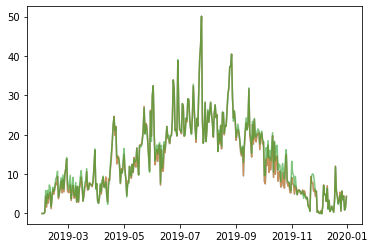

In [82]:
dates = out[0]
print(dates[0])
dates = dates[1]
dd = dates
dates = dates['date'].unique()


#print(dd)

bas = []
f5h = []
f5 = []
fma = []
cbas = []

fp1 = []
fds = []

ch5h = []
chma = []

for d in dates:
    dai = dd.loc[dd['date'] == d]

    bc =  dai.loc[dai['Q'] > 0]
    br =  dai.loc[dai['Q'] < 0]
    bc = sum(bc['Q'] / bc['COP'] * bc['COE'] * 0.5)
    br = sum(-1 * br['Q'] / br['COP'] * br['COE'] * 0.5)

    cf = sum(dai['COE'] * 0.5 * (dai['BAU El'] / 0.5))
    cbas.append(cf)

    cf = sum(dai['COE'] * 0.5 * (dai['BAU El'] / 0.5 + dai['Q'] / dai['COP']))

    

    bas.append([(br - bc)/100, cf])

    f = out[3][1].loc[ out[3][1]['date'] == d]

    fc =  f.loc[f['Q'] > 0]
    fr =  f.loc[f['Q'] < 0]
    fc = sum(fc['Q'] / fc['COP'] * fc['COE'] * 0.5)
    fr = sum(-1 * fr['Q'] / fr['COP'] * fr['COE'] * 0.5)

    cf = sum(dai['COE'] * 0.5 * (dai['BAU El'] / 0.5 + f['Q'] / dai['COP']))

    
    ch5h.append(len(f.loc[(f['Q'] < f['MaxDis']) & (f['PCM Mode'] == 'discharging')]))
    f5h.append([(fr - fc)/100])

    f = out[2][1].loc[ out[2][1]['date'] == d]

    ff = sum((((dai['BAU El'] +  ((f['Q'] * 0.5) / f['COP'])) *f['COE'] )/100) - dai['BAU Cost (GBP)'])

    # fc =  f.loc[f['Q'] > 0]
    # fr =  f.loc[f['Q'] < 0]
    # fc = sum(fc['Q'] / fc['COP'] * fc['COE'] / 0.5)
    # fr = sum(-1 * fr['Q'] / fr['COP'] * fr['COE'] / 0.5)

    f5.append(ff)

    f = out[4][1].loc[ out[4][1]['date'] == d]

    fc =  f.loc[f['Q'] > 0]
    fr =  f.loc[f['Q'] < 0]
    fc = sum(fc['Q'] / fc['COP'] * fc['COE'] * 0.5)
    fr = sum(-1 * fr['Q'] / fr['COP'] * fr['COE'] * 0.5)

    chma.append(len(f.loc[(f['Q'] < f['MaxDis']) & (f['PCM Mode'] == 'discharging')]))

    fma.append((fr - fc)/100)

    f = out[6][1].loc[ out[6][1]['date'] == d]

    ff = sum((((dai['BAU El'] +  ((f['Q'] * 0.5) / f['COP'])) *dai['COE'] )/100) - dai['BAU Cost (GBP)'])

    fp1.append(ff)

    
    f = out[7][1].loc[ out[7][1]['date'] == d]

    ff = sum((((dai['BAU El'] +  ((f['Q'] * 0.5) / f['COP'])) *dai['COE'] )/100) - dai['BAU Cost (GBP)'])

    fds.append(ff)
    #dailies['profits'] = [sum(dd.loc[dd['date'] == d]['Real Cost']) for d in dates]

#print(dailies)


print(ch5h)

dailies = pd.DataFrame()
dailies['date'] = dates
dailies['base'] = np.array(bas)[:, 0]
dailies['f5h'] = np.array(f5h)[:, 0]
dailies['f5'] = -1 *  np.array(f5)
dailies['fma'] = fma
dailies['fp1'] = -1 * np.array(fp1)
dailies['fds'] = -1 * np.array(fds) 
dailies['ch5h'] = ch5h
dailies['chma'] = chma


#plt.plot(dailies['date'], dailies['f5h'])
# plt.plot(dd['date'], dd['COE'] * 0.5 * (dd['BAU El'] / 0.5), alpha=.6)
# plt.plot(dd['date'], dd['COE'] * 0.5 * (dd['Q'] / dd['COP']), alpha=.6)

# plt.hist(dd['COE'] * 0.5 * (dd['BAU El'] / 0.5 + out[10][1]['Q'] / dd['COP'] ),alpha=.6, bins=40, histtype="step")
plt.plot(dailies['date'], dailies['fma'], alpha=.6)

plt.plot(dailies['date'], dailies['f5h'], alpha=.6)
plt.plot(dailies['date'], dailies['base'],alpha=.6)

#plt.plot(dailies['date'], dailies['fma'], alpha=.6)

#
#plt.hist(dd['Q'])

#plt.hist(out[10][1]['Q'])


print(dailies['f5h'].sum())
print(dailies['base'].sum())
print(dailies['fma'].sum())
print(dailies['ch5h'].sum())
print(dailies['chma'].sum())

#print(dd)



In [21]:
5983.294793973451
5983.281501754401

5983.281501754401

In [63]:
import plotly
import plotly.graph_objs as go

traceb = go.Trace(
    x = dailies['date'],
    y = dailies['base'],
    name = 'Load Model Base',
    marker=dict(
            color='#004A9C',)
)

tracep1 = go.Trace(
    x = dailies['date'],
    y = dailies['f5h'],
    name = 'Load Model MA',
    marker=dict(
            color='#45D281',)
)

tracedu = go.Trace(
    x = dailies['date'],
    y = dailies['fma'],
    name = 'Load Model MA',
    marker=dict(color = '#FEC001')
)

# tracepred = go.Trace(
#     x = monthly['Date'],
#     y = monthly['Pred'],
#     name = 'Price Model Comb',
#     marker=dict(color = '#A365E0')
# )

figPr = go.Figure()

figPr.add_trace(tracep1)
figPr.add_trace(tracedu)
figPr.add_trace(traceb)

figPr.update_layout(
    title="Sensitivity Analysis 2019 - Daily Profits - Price Forecast",
    xaxis_title="Months",
    yaxis_title="Profts (GBP)",
    font=dict(
        size=15,
        color="black"
    ),
    showlegend=True,
    #paper_bgcolor='rgba(255,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0.1)'
    
)

figPr.show()

In [190]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Annual Refrigeration Demand')
ax1.set_ylabel('mult constant', color=color)
ax1.plot(profits[:, 2], profits[:, 2]/profits[0, 2], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([0.85,1.3])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Annual Profits', color=color)  # we already handled the x-label with ax1
ax2.plot(profits[:, 2], profits[:, 0], color=color)
ax2.scatter(dd[:, 1], dd[:, 0], color='black', s=10, marker='x',)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([5770, 5992])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

TypeError: '(slice(None, None, None), 1)' is an invalid key

In [63]:
profits = []
datas = []
for f in files:
    data = pd.read_pickle(f)
    #print(data)

    cc =  data.loc[data['Q_dot'] > 0]
    cr =  data.loc[data['Q_dot'] < 0]
    cc = sum(cc['Q_dot'] / cc['COP'] * cc['dt * CoE'])
    cr = sum(-1 * cr['Q_dot'] / cr['COP'] * cr['dt * CoE'])
    #print(f[19:-10])
    datas.append(data)
    profits.append([(cr - cc)/100, int(f[19:-10]), data['Loads(kWh)'].sum()])

profits.sort(key=lambda x:x[1])
print(profits)
profits = np.array(profits)

mults = np.arange(1., 3., 0.04)

print(profits[:, 2]/mults)



[[5781.453128943735, 0, 673045.0], [5824.842127285187, 1, 699966.8], [5861.494626730086, 2, 726888.6000000001], [5890.593810925379, 3, 753810.4], [5914.499356869649, 4, 780732.2000000001], [5933.181437697298, 5, 807654.0000000001], [5947.405666842275, 6, 834575.8000000002], [5957.922533628264, 7, 861497.6000000002], [5965.395180459903, 8, 888419.4000000001], [5970.786981330759, 9, 915341.2000000002], [5974.580934673469, 10, 942263.0000000002], [5977.217796933243, 11, 969184.8000000002], [5979.131073607076, 12, 996106.6000000003], [5980.398126091691, 13, 1023028.4000000004], [5981.322321431063, 14, 1049950.2000000004], [5981.964943194707, 15, 1076872.0000000005], [5982.368646615481, 16, 1103793.8000000003], [5982.698173481522, 17, 1130715.6000000003], [5982.879347238062, 18, 1157637.4000000006], [5983.011675325275, 19, 1184559.2000000007], [5983.0992282156085, 20, 1211481.0000000005], [5983.1546227338395, 21, 1238402.8000000005], [5983.18321860865, 22, 1265324.6000000006], [5983.2030773

In [56]:




#dats = []

test = pd.read_pickle('./output/mult_base/0003_Base_Load_300_const.pkl')
cc =  test.loc[test['Q_dot'] > 0]
cr =  test.loc[test['Q_dot'] < 0]
cc = sum(cc['Q_dot'] / cc['COP'] * cc['dt * CoE'])
cr = sum(-1 * cr['Q_dot'] / cr['COP'] * cr['dt * CoE'])
print((cr - cc)/100)

y = (test['Q_dot'] - base['Q_dot'])
print(y.loc[y.values != 0])

x = datas[0] 

print(x)

print(x['Q_dot'] - base['Q_dot'])
print(test['Loads(kWh)'].sum())

# dats.append(base)
# dats.append(load1)
# dats.append(load5)
# dats.append(load5h)
# dats.append(loadma)
# #dats.append(pred)
# #dats.append(price1)
# #dats.append(priced)

dd = []

for data in dats:
    #data = pd.read_pickle(f)
    #print(data)

    cc =  data.loc[data['Q_dot'] > 0]
    cr =  data.loc[data['Q_dot'] < 0]
    cc = sum(cc['Q_dot'] / cc['COP'] * cc['dt * CoE'])
    cr = sum(-1 * cr['Q_dot'] / cr['COP'] * cr['dt * CoE'])
    #print(f[19:-10])
    dd.append([(cr - cc)/100, data['Loads(kWh)'].sum()])

dd = np.array(dd)

5781.453128943735
Series([], Name: Q_dot, dtype: float64)
             Date  HH  Q_dot         Mode   SOC  dt * CoE  BAU COE  \
0      2019-01-31   1   80.0     charging  40.0     5.315    10.63   
1      2019-01-31   2    0.0      standby  40.0     6.015    12.03   
2      2019-01-31   3  -80.0  discharging   0.0     6.250    12.50   
3      2019-01-31   4   80.0     charging  40.0     5.830    11.66   
4      2019-01-31   5  -40.0  discharging  20.0     5.830    11.66   
...           ...  ..    ...          ...   ...       ...      ...   
16075  2019-12-31  44   80.0     charging  40.0     3.620     7.24   
16076  2019-12-31  45  -80.0  discharging   0.0     4.035     8.07   
16077  2019-12-31  46   80.0     charging  40.0     3.595     7.19   
16078  2019-12-31  47   80.0     charging  80.0     3.960     7.92   
16079  2019-12-31  48  -80.0  discharging  40.0     4.290     8.58   

       Loads(kWh)  Temp     COP    DCOP  Max  sDelta  
0           38.64   1.0  5.3860  5.3860  0.0  

In [64]:
profits = profits[ : -20]
mults = mults[:-20]

print(dd)
print(profits)
print(mults)

[[  5781.45312894 673045.        ]
 [  5802.45070651 699978.6942    ]
 [  5813.27972966 697166.197     ]
 [  5819.84741455 701770.62827731]
 [  5710.217735   711840.        ]
 [  3066.6453775  697166.197     ]
 [  3050.80960396 673045.        ]
 [  1594.18734827 673045.        ]]
[[5.78145313e+03 0.00000000e+00 6.73045000e+05]
 [5.82484213e+03 1.00000000e+00 6.99966800e+05]
 [5.86149463e+03 2.00000000e+00 7.26888600e+05]
 [5.89059381e+03 3.00000000e+00 7.53810400e+05]
 [5.91449936e+03 4.00000000e+00 7.80732200e+05]
 [5.93318144e+03 5.00000000e+00 8.07654000e+05]
 [5.94740567e+03 6.00000000e+00 8.34575800e+05]
 [5.95792253e+03 7.00000000e+00 8.61497600e+05]
 [5.96539518e+03 8.00000000e+00 8.88419400e+05]
 [5.97078698e+03 9.00000000e+00 9.15341200e+05]
 [5.97458093e+03 1.00000000e+01 9.42263000e+05]
 [5.97721780e+03 1.10000000e+01 9.69184800e+05]
 [5.97913107e+03 1.20000000e+01 9.96106600e+05]
 [5.98039813e+03 1.30000000e+01 1.02302840e+06]
 [5.98132232e+03 1.40000000e+01 1.04995020e+06]

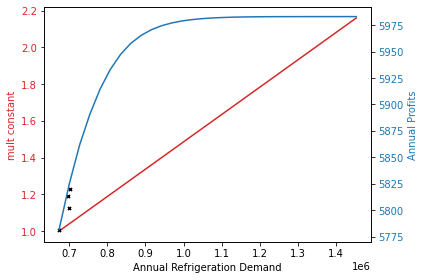

In [67]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Annual Refrigeration Demand')
ax1.set_ylabel('mult constant', color=color)
ax1.plot(profits[:, 2], profits[:, 2]/profits[0, 2], color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([0.85,1.3])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Annual Profits', color=color)  # we already handled the x-label with ax1
ax2.plot(profits[:, 2], profits[:, 0], color=color)
ax2.scatter(dd[:, 1], dd[:, 0], color='black', s=10, marker='x',)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([5770, 5992])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
#plt.plot(profits[:, 2], profits[:, 0])
#plt.plot(profits[:, 2], mults)

